<img src="https://gitlab.com/alessandro.bombini.fi/image-inpainting-tutorial/-/raw/master/pics/EOSc-Pillar_logo_final.png"/>

# Image Inpainting - an Intro

<img src="https://gitlab.com/alessandro.bombini.fi/image-inpainting-tutorial/-/raw/master/pics/Logo_INFN_CHNet_esteso.png" alt="Drawing" style="width: 250px; float: right"/>

Inpainting is a conservation process where damaged, deteriorating, or missing parts of an artwork are filled in to present a complete image. This process can be applied to both physical and digital art mediums such as oil or acrylic paintings, chemical photographic prints, 3-dimensional sculptures, or digital images and video.

Here we show a dummy example of Image Inpainting by means of Convolutional Neural Network. 

As a first example, we apply a digital damage to a set of 32x32 RGB images; the damage consists in adding a random number of black segments on top of the RGB image (mimicking cuts on the surface). 

After that, we train a 2D Convolutional Neural Network of the U-Net type (https://arxiv.org/abs/1505.04597); 



U-Nets are 2D CNN of the Encoder/Decoder type which are completely symmetrical, i.e. if it has $N$ layers, the $k$ and the $N-k$ layer have the same dimensions, and each layer of the encoding part is forwardly connected either with the subsequent encoding layer and with the symmetrical decoding layer; this means that it can be graphically arranged in a U-shape, hence the name. A graphical representation from (https://www.researchgate.net/publication/323597886_Lunar_Crater_Identification_via_Deep_Learning/figures?lo=1&utm_source=google&utm_medium=organic) is shown below:

![https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

In this notebook, we will build a network this form: 
0. Input Layer
1. Conv2D x2 + MaxPool2D 
2. Conv2D x2 + MaxPool2D 
3. Conv2D x2 + MaxPool2D 
4. Conv2D x2 + MaxPool2D 
5. Conv2D x2 + Upsampling + Concatenate (4,5)
6. Conv2D x2 + Upsampling + Concatenate (3,6)
7. Conv2D x2 + Upsampling + Concatenate (2,7)
8. Conv2D x2 + Upsampling + Concatenate (1,8)
9. OutPut Layer to RGB


So that, graphically appears as:
<img src="https://gitlab.com/alessandro.bombini.fi/image-inpainting-tutorial/-/raw/master/pics/UNet-eg-32x32.jpg"/>

In [2]:
import os
import cv2
import numpy as np
import pandas as pd

import keras

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid

## 1. Dataset

For the training of the 32x32 case we will use the CIFAR dataset ( https://www.cs.toronto.edu/~kriz/cifar.html ). 
It consists in 50.000 RGB 32 x 32 images.

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


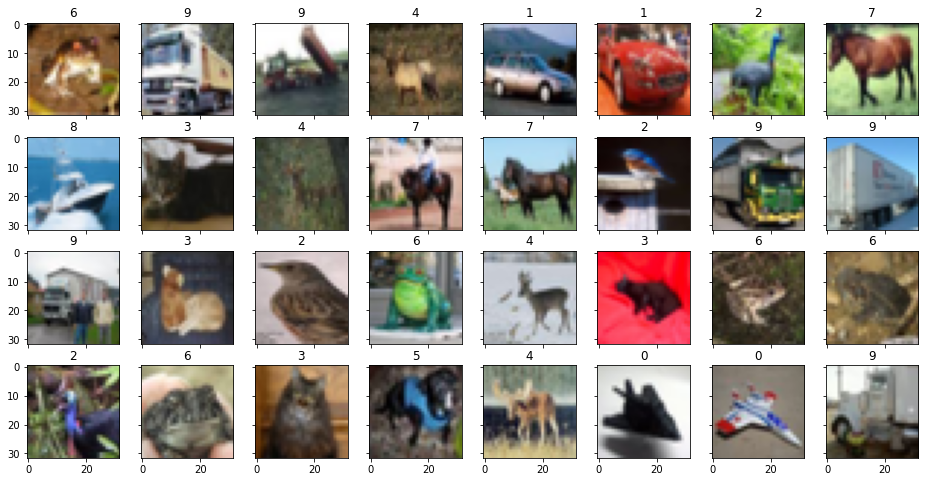

In [3]:
## Cifar 10 Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


## Get first 32 images as samples
sample_images = x_train[:32]
sample_labels = y_train[:32]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image, label in zip(grid, sample_images, sample_labels):
    ax.imshow(image)
    ax.set_title(label[0])

plt.show()

## 2. Training dataset: generating "masked" images

### 2.1. Definition of the damaging class

The mask is an ensamble of randomly generated segments; (the endpoints (x,y) coordinates and the thickness of the segments are randomly picked). The class method is __createMask. 

The createAugment class exteds keras.utils.Sequence ( https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence ) and thus inherits from it the methods:
1. __init___
2. __len__
3. __getitem__
4. on_epoch_end

We finally implement, on each batch, the custom method
- __createMask


In [4]:
## Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly 
class createAugment(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, X, y, batch_size=32, dim=(32, 32), n_channels=3, shuffle=True):
        'Initialization'
        self.batch_size = batch_size 
        self.X = X 
        self.y = y
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle

        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, idxs):
        # X_batch is a matrix of masked images used as input
        X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
        # y_batch is a matrix of original images used for computing error from reconstructed image
        y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image

        ## Iterate through random indexes
        for i, idx in enumerate(idxs):
            image_copy = self.X[idx].copy()

            ## Get mask associated to that image
            masked_image = self.__createMask(image_copy)

            X_batch[i,] = masked_image/255
            y_batch[i] = self.y[idx]/255

        return X_batch, y_batch

    def __createMask(self, img):
        ## Prepare masking matrix
        mask = np.full((32,32,3), 255, np.uint8)
        for _ in range(np.random.randint(1, 10)):
            # Get random x locations to start line
            x1, x2 = np.random.randint(1, 32), np.random.randint(1, 32)
            # Get random y locations to start line
            y1, y2 = np.random.randint(1, 32), np.random.randint(1, 32)
            # Get random thickness of the line drawn
            thickness = np.random.randint(1, 3)
            # Draw black line on the white mask
            cv2.line(mask,(x1,y1),(x2,y2),(1,1,1),thickness)

        # Perforn bitwise "and" operation to mak the image
        masked_image = cv2.bitwise_and(img, mask)

        return masked_image

#### Small note
The Cifar 10 datasets it is already dividend in 50.000 training images and 10.000 test images; we need to "augment" both of them, thus creating training and test "masked" dataset.

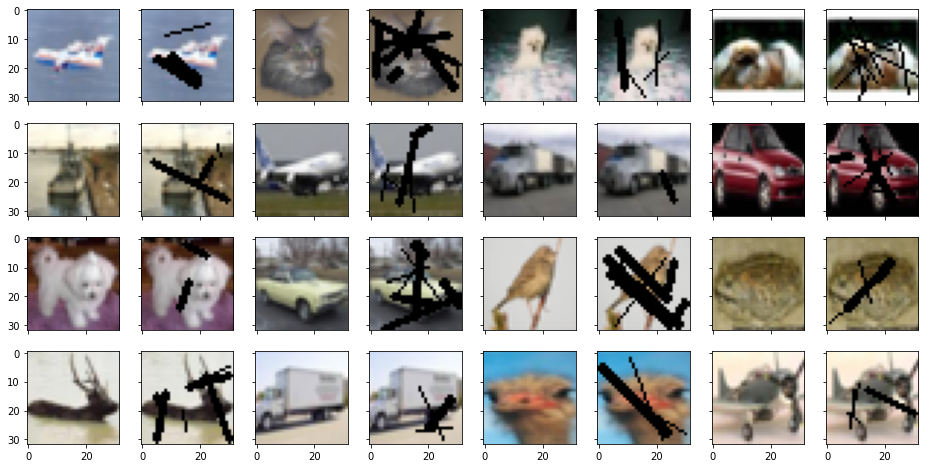

In [5]:
#################################################################################
## training and testing mask-image pair generator
traingen = createAugment(x_train, x_train)
testgen = createAugment(x_test, x_test, shuffle=False)
#################################################################################


## Examples
sample_idx = 90 ## Change this to see different batches

sample_masks, sample_labels = traingen[sample_idx]
sample_images = [None]*(len(sample_masks)+len(sample_labels))
sample_images[::2] = sample_labels
sample_images[1::2] = sample_masks

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
    ax.imshow(image)

plt.show()

## 3.  Definition of the model

### 3.1. Error metric
We will emplotu the IoU metric - Intersection over Union, i.e.
$$ \mathrm{IoU} (y_{pred}, y_{true} ) = \frac{ y_{pred} \cap y_ {true} }{ y_{pred} \cup y_ {true} } $$

Sometimes it is dubbed Jaccard Index ( https://en.wikipedia.org/wiki/Jaccard_index ). 

Here we empliy the matrix product (after flattening) as intesection, and their sum as union.

In [6]:
## For more information into formulation: https://www.youtube.com/watch?v=AZr64OxshLo
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

### 3.2. Definition of the model

We use a UNet 2D CNN; for simplicity, we use only Max Pooling, Conv2D, and Conv2DTranspose layers. 

We define the class "inpaintingModel" which will have the method prepare_model to prepare the model; we also define the convolution blocks (made with 2 Conv2D and a MaxPooling) and an upsampling block (made with 2 Conv2D, a Conv2DTranspose and a concatenate layer),  called __ConvBlock and __UpConvBLock

In [7]:
class inpaintingModel:
    '''
    Build UNET like model for image inpaining task.
    '''
    def prepare_model(self, input_size=(32,32,3)):
        inputs = keras.layers.Input(input_size)

        conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', inputs) 
        conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
        conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2) 
        conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3) 

        conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
        conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
        conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
        conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)

        conv9 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)

        outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

        return keras.models.Model(inputs=[inputs], outputs=[outputs])  

    def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        if pool_layer:
            pool = keras.layers.MaxPooling2D(pool_size)(conv)
            return conv, pool
        else:
            return conv

    def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
        up = keras.layers.concatenate([up, shared_layer], axis=3)

        return conv, up

### 3.3. Instantiating  the model

Here we instantiate the model; we will use the ADAM optimizer (https://arxiv.org/abs/1412.6980);

##### ADAM Algorithm
Adam, is an algorithm for stochastic optimization. $g^2_t$ indicates the elementwise
square $g_t \otimes g_t$. Good default settings for the tested machine learning problems are $\alpha = 0.001$,
$\beta_1 = 0.9$, $\beta_2 = 0.999$ and $ \epsilon = 10^{−8}$. All operations on vectors are element-wise. 

<b>Require</b>: $\alpha$: Stepsize

<b>Require</b>: $\beta_1, \beta_2 \in [ 0, 1 )$: Exponential decay rates for the moment estimates

<b>Require</b>: $f(\theta)$: Stochastic objective function with parameters θ

<b>Require</b>: $\theta_0$: Initial parameter vector
- $m_0 \leftarrow 0$ (Initialize 1st moment vector)
- $v_0 \leftarrow 0$ (Initialize 2nd moment vector)
- $t \leftarrow 0$ (Initialize timestep)
    
    
<b>while</b> $θ_t$ not converged <b>do</b>
- $t \leftarrow t + 1$   
- $g_t \leftarrow ∇_\theta f_t(\theta_{t−1})$ (Get gradients w.r.t. stochastic objective at timestep t)   
- $m_t \leftarrow \beta_1 \cdot m_{t − 1} + (1 − \beta_1) \cdot g_t$ (Update biased first moment estimate)
- $v_t \leftarrow \beta_2 \cdot v_{t − 1} + (1 − \beta_2) \cdot g_t^2$ (Update biased second raw moment estimate)
- $\hat{m}_t \leftarrow m_t/(1 − \beta_t^2)$ (Compute bias-corrected first moment estimate)
- $\hat{v}_t \leftarrow v_t/(1 − \beta_t^2)$ (Compute bias-corrected second raw moment estimate)   
- $\theta_t \leftarrow \theta_{t − 1} − \alpha \cdot \hat{m}_t/(\sqrt{\hat{v}_t} + \epsilon)$ (Update parameters)
   
   <b>end while</b>
    
   <b>return</b> $\theta_t$ (Resulting parameters)


##### Loss Function
We will use the Mean Absolute Error as Loss Function:
$$\mathrm{loss} = \sum_{i=0}^{\# \mathrm{batch}-1} \left| \left(y_{true}\right)_i - \left(y_{pred}\right)_i  \right|$$

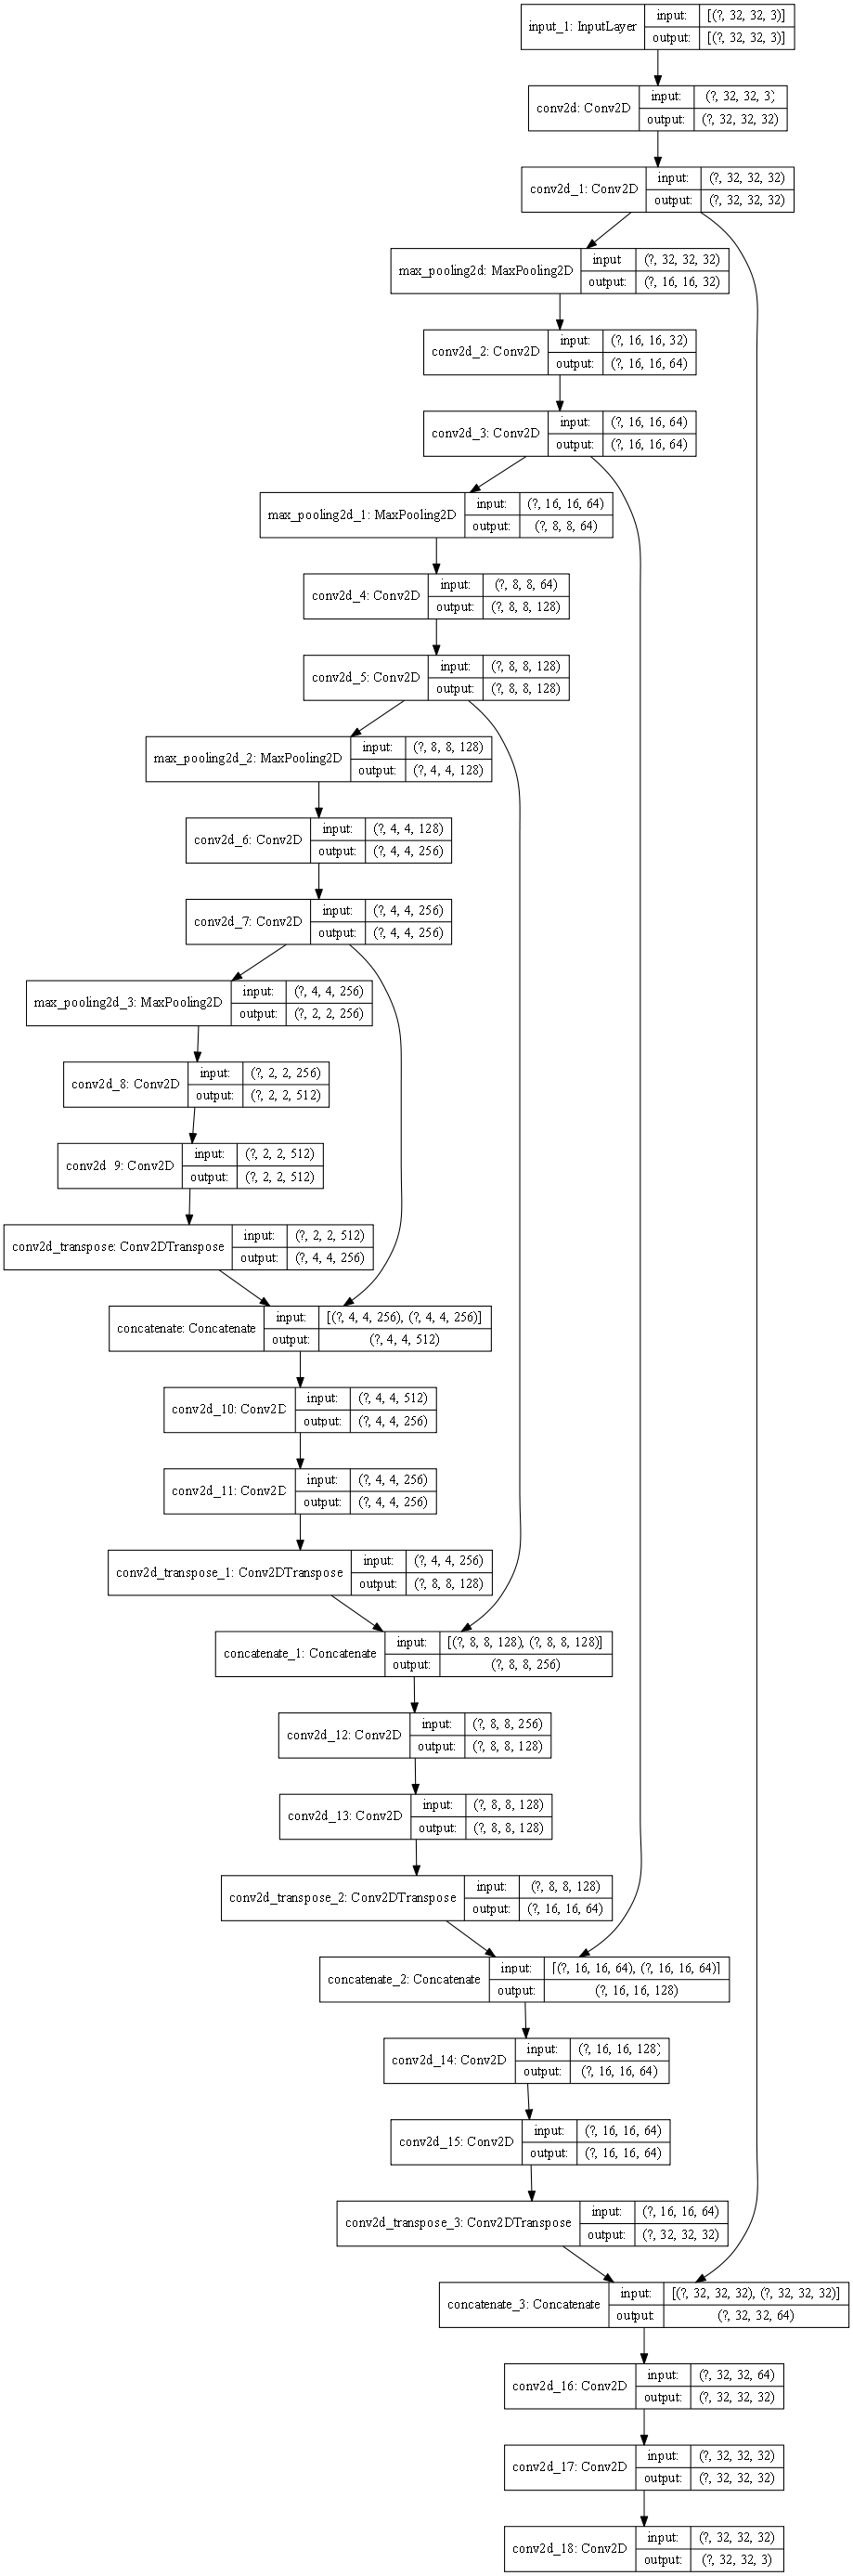

In [8]:
keras.backend.clear_session()
model = inpaintingModel().prepare_model()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])
keras.utils.plot_model(model, show_shapes=True, dpi=76, to_file='model_v1.png')

## 4. Fitting the model

We fit the training data on 20 epochs, using multiprocessing.

In [ ]:
_ = model.fit(traingen, 
          validation_data=testgen, 
          epochs=20, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen),
          use_multiprocessing=True)

Epoch 1/20


### 4.1. Exporting the model

We finally export the model and model infos, to reuse it later in other notebooks.

In [ ]:
# serialize weights to HDF5
import datetime
now = datetime.datetime.now()
time_string = now.strftime("%Y-%m-%d-%H-%M-%S")
path_to_model = 'Model_data/model_v' + time_string + '.h5'
model.save(path_to_model)
print("Saved model to disk")

# serialize model to JSON
path_to_json = 'Model_data/model_v' + time_string + '.json'
model_json = model.to_json()
# NB: open( "name", "w+") with the "w+" element creates a new file if it doesn't exists
with open(path_to_json, "w+") as json_file:
    json_file.write(model_json)
print('Model as JSON saved');

### 4.2. History of the Fit

In [ ]:
training_loss = _.history["loss"]
validation_loss = _.history["val_loss"]
train_acc = _.history["dice_coef"]
val_acc = _.history['val_dice_coef']

epoch_nums = range(1, len(val_acc)+1)

plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')

plt.subplot(1,2,2)
plt.plot(epoch_nums, train_acc)
plt.plot(epoch_nums, val_acc)
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.legend(['training', 'validation'], loc='lower right')

plt.show()

<img src="https://gitlab.com/alessandro.bombini.fi/image-inpainting-tutorial/-/raw/master/pics/Logo_INFN_CHNet_esteso.png" alt="Drawing" style="width: 400px;"/>

<img src="https://gitlab.com/alessandro.bombini.fi/image-inpainting-tutorial/-/raw/master/pics/EOSc-Pillar_logo_final_Squared.png" alt="Drawing"/>